In [1]:
#Import libraries
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from tqdm.notebook import tqdm
from scipy import stats

/usr/local/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


<h3>1. Loading train data

In [2]:
data = pd.read_csv('train.csv')
data.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


In [3]:
data.shape

(4209, 378)

<h3>1.2. Missing values</h3>

In [4]:
miss = data.isnull().sum(axis=0)  #Sum of nan values for all columns
miss.head()

ID    0
y     0
X0    0
X1    0
X2    0
dtype: int64

In [5]:
miss.value_counts()

0    378
dtype: int64

There are no missing values across all the columns

<h3>1.3. Split the dataset</h3>

In [6]:
X = data.drop(columns=['y'])
Y = data['y']

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=25) 

In [8]:
print(X_train.shape)
print(X_val.shape)

(3367, 377)
(842, 377)


In [9]:
train_data = pd.merge(X_train,y_train.to_frame(),left_index=True, right_index=True)

In [10]:
train_data.head()

,ID,X0,X1,X2,X3,X4,X5,X6,X8,X10,...,X376,X377,X378,X379,X380,X382,X383,X384,X385,y
3127,6265,y,r,f,f,d,q,j,s,0,...,0,0,0,0,0,0,0,0,0,85.55
1474,2935,y,a,ak,f,d,ac,d,x,0,...,0,0,0,0,0,0,0,0,0,98.51
1206,2405,au,aa,as,a,d,ab,d,m,0,...,1,0,0,0,0,0,0,0,0,111.50
3104,6231,ba,b,ai,a,d,q,k,u,0,...,0,1,0,0,0,0,0,0,0,95.51
3526,7043,x,v,e,c,d,r,g,s,0,...,0,0,0,1,0,0,0,0,0,110.59


In [11]:
train_data.shape

(3367, 378)

<h3>1.4. Analyse dependent variable y</h3>

Text(0.5, 1.0, 'Boxplot of time')

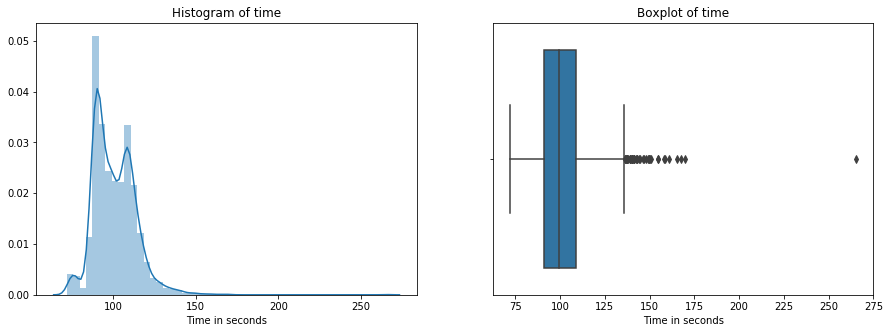

In [12]:
#Distribution of y
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(train_data['y'])
plt.xlabel('Time in seconds')
plt.title('Histogram of time')
plt.subplot(1,2,2)
sns.boxplot(train_data['y'])
plt.xlabel('Time in seconds')
plt.title('Boxplot of time')

Mean of time is 100 seconds. Points with y values greater than 137 can be classified as outliers. Data points with y greater than 150 are removed.

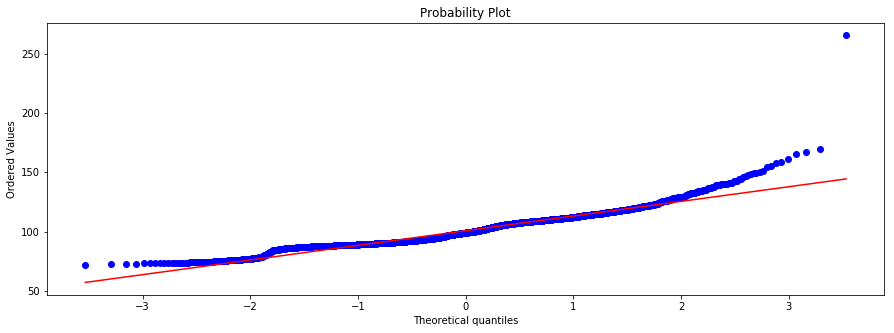

In [13]:
plt.figure(figsize=(15,5))
a = stats.probplot(train_data['y'],dist='norm',plot=plt) 

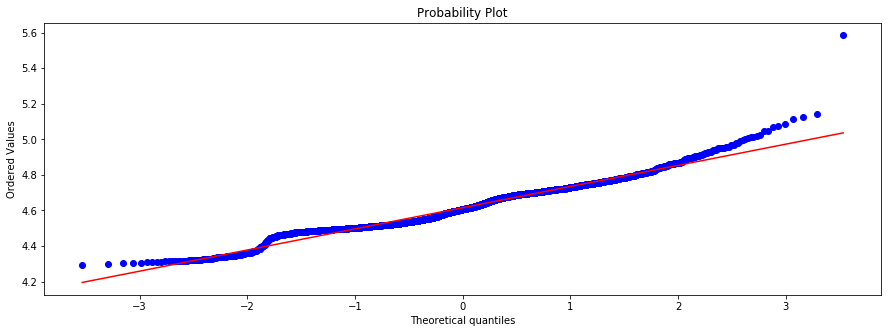

In [14]:
plt.figure(figsize=(15,5))
a = stats.probplot(np.log1p(train_data['y']),dist='norm',plot=plt) 

Taking log transformation of dependent variable does not result in significant change in distribution.

In [15]:
#Remove outliers
train_data = train_data[train_data['y']<=150]

In [16]:
train_data.shape

(3356, 378)

In [17]:
train_data_type = train_data.dtypes
train_data_type.value_counts()

int64      369
object       8
float64      1
dtype: int64

In [18]:
train_data_type.head(15)

ID      int64
X0     object
X1     object
X2     object
X3     object
X4     object
X5     object
X6     object
X8     object
X10     int64
X11     int64
X12     int64
X13     int64
X14     int64
X15     int64
dtype: object

There are 8 categorical variables and 368 numerical variables. All numerical features are binary variables.

<h3>1.5. Analyse categorical variables</h3>

In [19]:
def univariate_cat(dataset):
    """
    This function prints the barplots of counts of unique values of feature and boxplots of unique values of feature.
    Dataset must have two columns namely categorical feature and target variable
    """
    var = dataset.columns[0]
    a = dataset[var].value_counts()
    print('Unique values of {}: {}'.format(var,list(a.index)))
    print('No of unique values of {}: {}'.format(var,len(a.index)))
    plt.figure(figsize=(15,10))
    plt.subplot(211)
    g = sns.barplot(x=a.index, y=a.values)
    for i,j in enumerate(a.values):
        g.text(i,j,str(round(j*100/sum(a.values),1))+'%',ha='center')  #Percentage of points
    plt.title('Counts of unique values of {}'.format(var))
    plt.subplot(212)
    sns.boxplot(x=dataset[var],y=dataset['y'],order=a.index)
    plt.title('Boxplots for unique values of {}'.format(var))
    
    #Get categories which occur more than 5 times in dataset
    b = list(filter(lambda x:x>5,a.values))    
    c = list(a.index[0:len(b)])

    return {j:i+1 for i,j in enumerate(c)}  #Dictionary of labels, unknown categories are assigned label 0

<h3>1.5.1. X0 feature</h3>

Unique values of X0: ['z', 'ak', 'y', 'ay', 'x', 't', 'o', 'f', 'n', 'j', 'w', 'az', 'aj', 'ap', 's', 'd', 'h', 'al', 'm', 'ai', 'e', 'v', 'af', 'ba', 'at', 'a', 'ax', 'i', 'aq', 'am', 'u', 'aw', 'l', 'au', 'ad', 'as', 'b', 'k', 'r', 'bc', 'ao', 'c', 'q', 'aa', 'g', 'ac', 'ab']
No of unique values of X0: 47


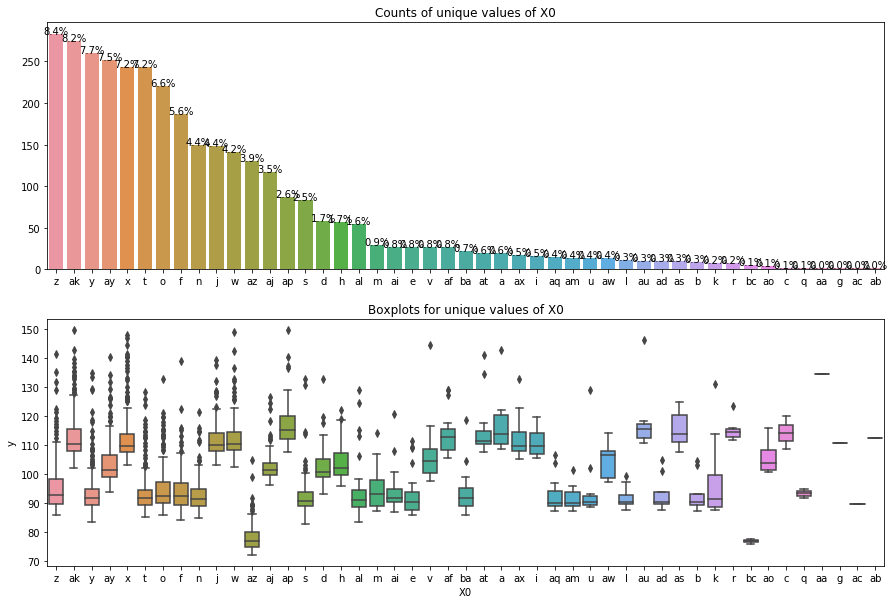

In [20]:
x0_labels = univariate_cat(train_data[['X0','y']])

1. aa, ab, g and ac occur only once. 
2. The boxplots of z, y, t, o, f, n, s, al, m, ai, e, ba, aq, am, u, i, ad and b are nearly same. The mean of these categories is nearly 93. 
3. The boxplots of ak, x, j, w, af, at, a, ax, i, au, as, r and c are nearly same. The mean of these categories is nearly 110.
4. Thus there appears to be grouping among different categories of X0.

In [21]:
x0_labels

{'a': 26,
 'ad': 35,
 'af': 23,
 'ai': 20,
 'aj': 13,
 'ak': 2,
 'al': 18,
 'am': 30,
 'ap': 14,
 'aq': 29,
 'as': 36,
 'at': 25,
 'au': 34,
 'aw': 32,
 'ax': 27,
 'ay': 4,
 'az': 12,
 'b': 37,
 'ba': 24,
 'd': 16,
 'e': 21,
 'f': 8,
 'h': 17,
 'i': 28,
 'j': 10,
 'k': 38,
 'l': 33,
 'm': 19,
 'n': 9,
 'o': 7,
 'r': 39,
 's': 15,
 't': 6,
 'u': 31,
 'v': 22,
 'w': 11,
 'x': 5,
 'y': 3,
 'z': 1}

In [22]:
train_data['X0'] = [x0_labels[i] if x0_labels.get(i) is not None else 0 for i in train_data['X0']]

<h3>1.5.2. X1 feature</h3>

Unique values of X1: ['aa', 'b', 's', 'l', 'v', 'r', 'i', 'a', 'c', 'o', 'w', 'u', 'z', 'e', 'h', 'm', 't', 'f', 'y', 'j', 'k', 'n', 'p', 'g', 'ab', 'd', 'q']
No of unique values of X1: 27


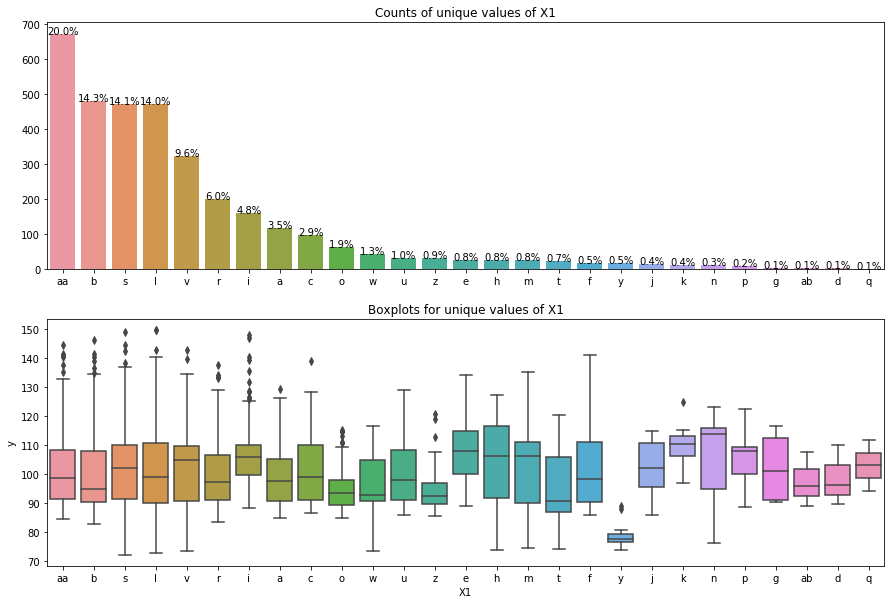

In [23]:
x1_labels = univariate_cat(train_data[['X1','y']])

1. Most of the categories of X1 have mean of 100.
2. y of X1 category is clearly separated from rest of the categories.

In [24]:
x1_labels

{'a': 8,
 'aa': 1,
 'b': 2,
 'c': 9,
 'e': 14,
 'f': 18,
 'h': 15,
 'i': 7,
 'j': 20,
 'k': 21,
 'l': 4,
 'm': 16,
 'n': 22,
 'o': 10,
 'p': 23,
 'r': 6,
 's': 3,
 't': 17,
 'u': 12,
 'v': 5,
 'w': 11,
 'y': 19,
 'z': 13}

In [25]:
train_data['X1'] = [x1_labels[i] if x1_labels.get(i) is not None else 0 for i in train_data['X1']]

<h3>1.5.3. X2 feature</h3>

Unique values of X2: ['as', 'ae', 'ai', 'm', 'ak', 'r', 'n', 's', 'f', 'e', 'aq', 'ay', 'a', 'i', 't', 'k', 'd', 'ao', 'z', 'b', 'ag', 'ac', 'y', 'g', 'ap', 'aw', 'x', 'al', 'an', 'p', 'av', 'ah', 'h', 'at', 'au', 'q', 'c', 'aa', 'ar', 'l', 'o', 'j']
No of unique values of X2: 42


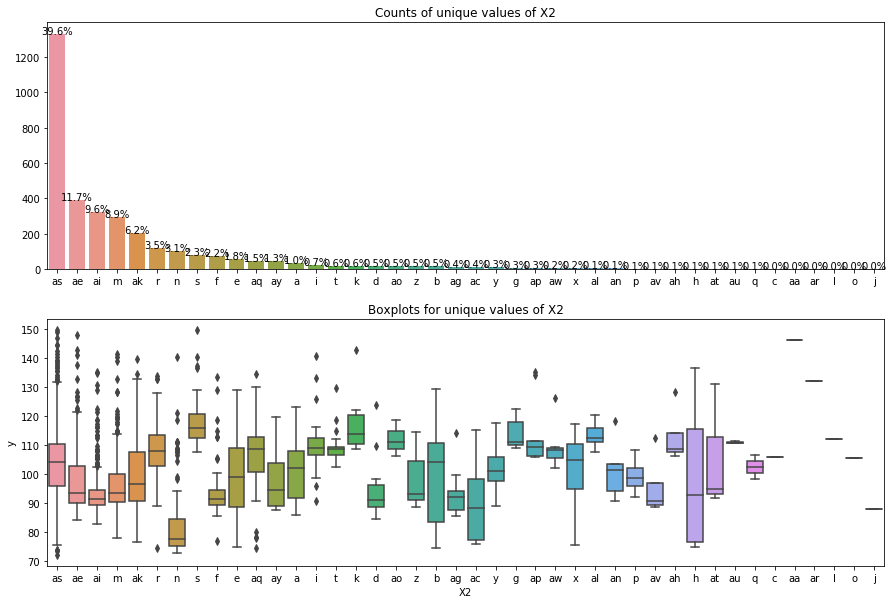

In [26]:
x2_labels = univariate_cat(train_data[['X2','y']])





1. ae category dominates in X2. 39% values of X2 are ae.
2. Similar to X0 there appears to be grouping in X2. X2 has less grouping than X0.
3. Most of categories of X2 have mean close to 97.

In [27]:
x2_labels

{'a': 13,
 'ac': 22,
 'ae': 2,
 'ag': 21,
 'ai': 3,
 'ak': 5,
 'ao': 18,
 'ap': 25,
 'aq': 11,
 'as': 1,
 'aw': 26,
 'ay': 12,
 'b': 20,
 'd': 17,
 'e': 10,
 'f': 9,
 'g': 24,
 'i': 14,
 'k': 16,
 'm': 4,
 'n': 7,
 'r': 6,
 's': 8,
 't': 15,
 'x': 27,
 'y': 23,
 'z': 19}

In [28]:
train_data['X2'] = [x2_labels[i] if x2_labels.get(i) is not None else 0 for i in train_data['X2']]

<h3>1.5.4. X3 feature</h3>

Unique values of X3: ['c', 'f', 'a', 'd', 'g', 'e', 'b']
No of unique values of X3: 7


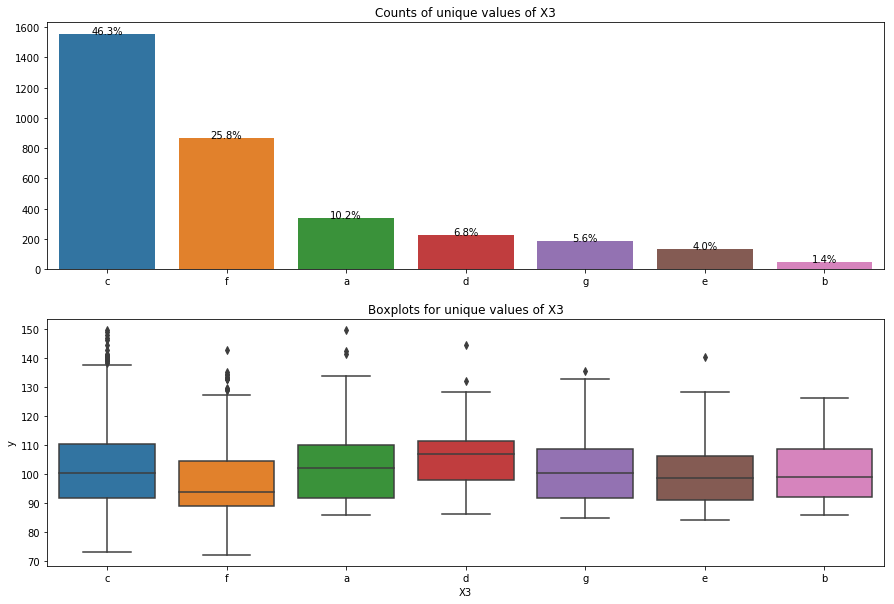

In [29]:
x3_labels = univariate_cat(train_data[['X3','y']])

1. c category dominates in X3. 46% values of X3 are c.
2. Almost all the categories of X3 have mean of 100.
3. There appears to be less variation in dependent variable y across the categories of X3. The boxplots for most of the categories of X3 match.

In [30]:
x3_labels

{'a': 3, 'b': 7, 'c': 1, 'd': 4, 'e': 6, 'f': 2, 'g': 5}

In [31]:
train_data['X3'] = [x3_labels[i] if x3_labels.get(i) is not None else 0 for i in train_data['X3']]

<h3>1.5.5. X4 feature</h3>

Unique values of X4: ['d', 'b', 'c', 'a']
No of unique values of X4: 4


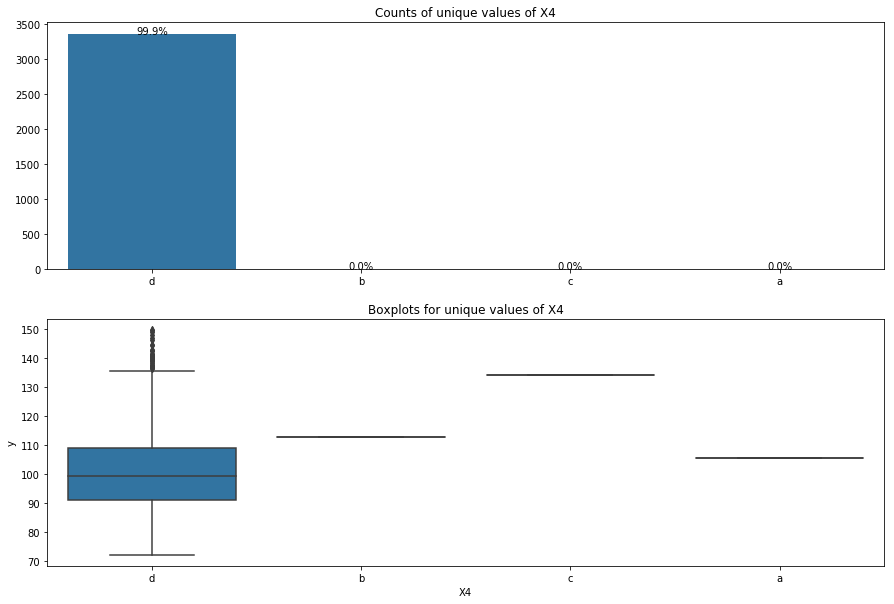

In [32]:
x4_labels = univariate_cat(train_data[['X4','y']])



1. d category dominates in X4. 99.9% values of X4 are d.
2. This feature must be dropped as there is no variance present in the feature.

In [33]:
train_data = train_data.drop('X4',axis=1)

<h3>1.5.6. X5 feature</h3>

Unique values of X5: ['v', 'q', 'w', 'i', 'd', 's', 'ae', 'p', 'af', 'n', 'r', 'ac', 'm', 'l', 'ag', 'ab', 'ad', 'k', 'j', 'c', 'aa', 'ah', 'o', 'f', 'x', 'y', 'g', 'u']
No of unique values of X5: 28


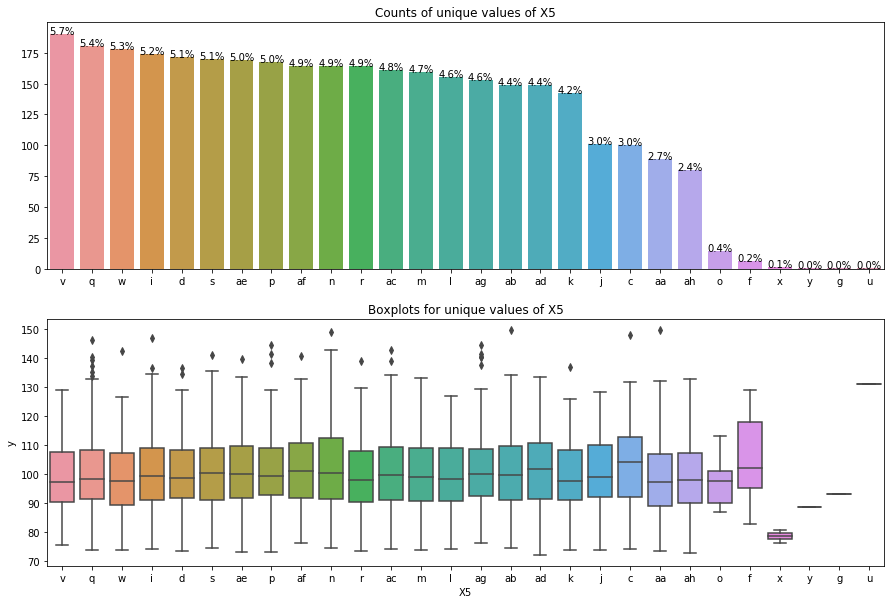

In [34]:
x5_labels = univariate_cat(train_data[['X5','y']])

1. x, h, g, y and u occur very rarely in the data.
2. The mean of all categories of X5 is close to 98.
3. There appears to be less variation in dependent variable y across the categories of X5. The boxplots for most of the categories of X5 match.

In [35]:
x5_labels

{'aa': 21,
 'ab': 16,
 'ac': 12,
 'ad': 17,
 'ae': 7,
 'af': 9,
 'ag': 15,
 'ah': 22,
 'c': 20,
 'd': 5,
 'f': 24,
 'i': 4,
 'j': 19,
 'k': 18,
 'l': 14,
 'm': 13,
 'n': 10,
 'o': 23,
 'p': 8,
 'q': 2,
 'r': 11,
 's': 6,
 'v': 1,
 'w': 3}

In [36]:
train_data['X5'] = [x5_labels[i] if x5_labels.get(i) is not None else 0 for i in train_data['X5']]

<h3>1.5.7. X6 feature</h3>

Unique values of X6: ['g', 'j', 'd', 'i', 'l', 'a', 'h', 'k', 'c', 'b', 'f', 'e']
No of unique values of X6: 12


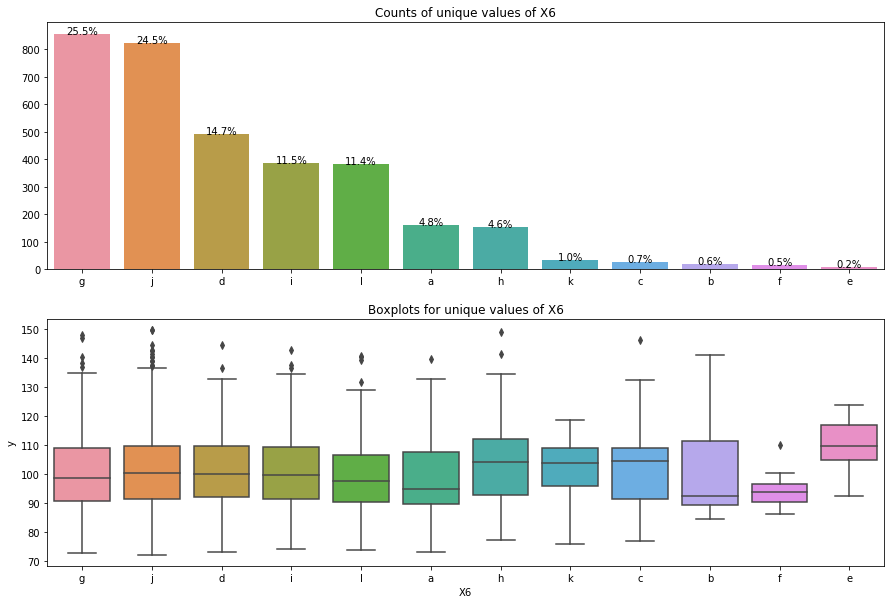

In [37]:
x6_labels = univariate_cat(train_data[['X6','y']])

1. Boxplots of j, g, d and i match each other. 
2. Most of the categories of X6 have mean around 100.
3. There appears to be less variation in dependent variable y across the categories of X6. The boxplots for most of the categories of X6 match.

In [38]:
x6_labels

{'a': 6,
 'b': 10,
 'c': 9,
 'd': 3,
 'e': 12,
 'f': 11,
 'g': 1,
 'h': 7,
 'i': 4,
 'j': 2,
 'k': 8,
 'l': 5}

In [39]:
train_data['X6'] = [x6_labels[i] if x6_labels.get(i) is not None else 0 for i in train_data['X6']]

<h3>1.5.8. X8 feature</h3>

Unique values of X8: ['j', 's', 'f', 'n', 'e', 'i', 'r', 'a', 'v', 'w', 'b', 'k', 'o', 'm', 'g', 'y', 'h', 't', 'u', 'x', 'q', 'p', 'l', 'c', 'd']
No of unique values of X8: 25


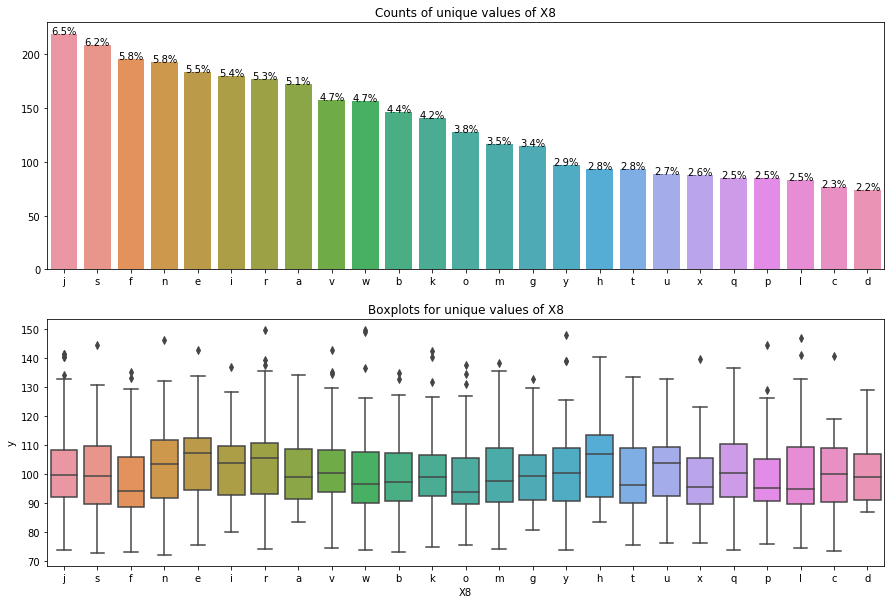

In [40]:
x8_labels = univariate_cat(train_data[['X8','y']])

1. The mean of most of the categories of X8 is close to 100.
2. There appears to be less variation in dependent variable y across the categories of X8. The boxplots for most of the categories of X8 match.

In [41]:
x8_labels

{'a': 8,
 'b': 11,
 'c': 24,
 'd': 25,
 'e': 5,
 'f': 3,
 'g': 15,
 'h': 17,
 'i': 6,
 'j': 1,
 'k': 12,
 'l': 23,
 'm': 14,
 'n': 4,
 'o': 13,
 'p': 22,
 'q': 21,
 'r': 7,
 's': 2,
 't': 18,
 'u': 19,
 'v': 9,
 'w': 10,
 'x': 20,
 'y': 16}

In [42]:
train_data['X8'] = [x8_labels[i] if x8_labels.get(i) is not None else 0 for i in train_data['X8']]

<h2>1.6. Analyse numerical features</h2>

In [43]:
len(train_data.columns)

377

In [44]:
num_cols = [i for i in train_data.columns if i not in ["ID", "y", "X0", "X1", "X2", "X3", "X5", "X6", "X8"]]

In [45]:
len(num_cols)

368

In [46]:
#Percentage of zeros in numerical features
zero_counts_per = [round(100*train_data[i].value_counts()[0]/train_data.shape[0],2) for i in num_cols]

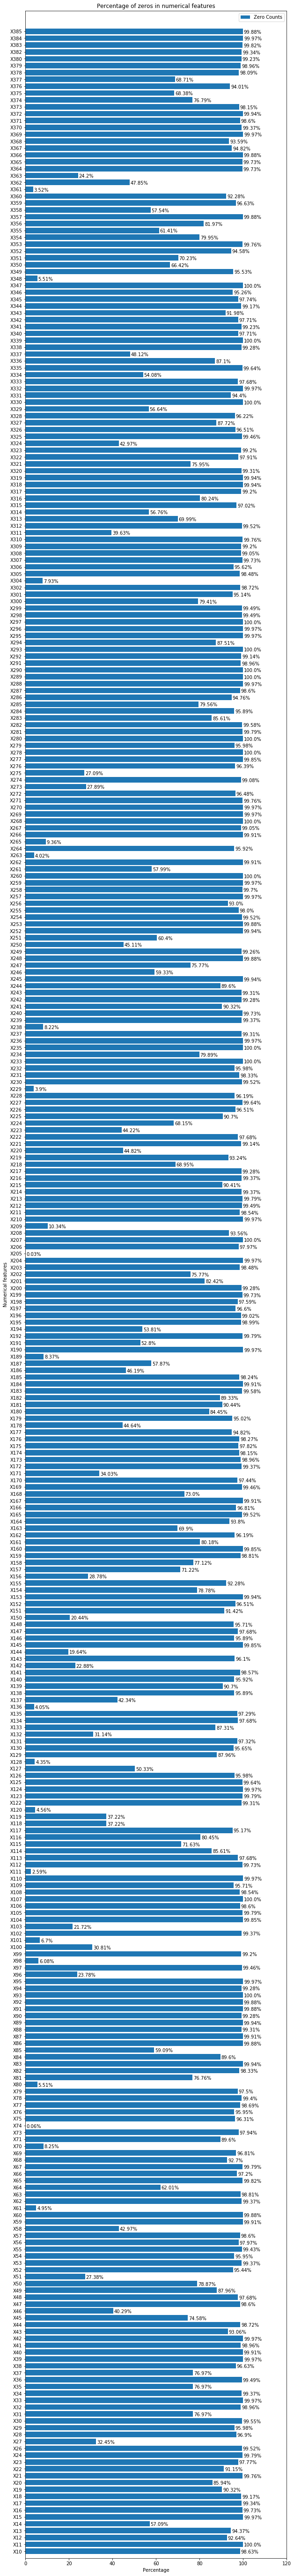

In [47]:
#https://robertmitchellv.com/blog-bar-chart-annotations-pandas-mpl.html
plt.figure(figsize=(10,100))
ind = np.arange(len(zero_counts_per))
ax = plt.barh(ind,zero_counts_per,label='Zero Counts')
plt.yticks(ind,num_cols)

# find the values and append to list
totals=[]
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar labels using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    plt.text(i.get_width()+.4, i.get_y()+.1, str(i.get_width())+'%')
plt.title('Percentage of zeros in numerical features')
plt.xlim(0,120)
plt.ylim(-1,370)
plt.xlabel('Percentage')
plt.ylabel('Numerical features')
plt.legend()

Features whose 99% values are either 0 or 1 are removed

In [48]:
rem_num_cols=[]
for i,j in zip(num_cols,zero_counts_per):
    if j>=99 or j<=1:
        rem_num_cols.append(i)

In [49]:
len(rem_num_cols)

146

In [50]:
train_data = train_data.drop(rem_num_cols,axis=1)

In [51]:
train_data.head()

,ID,X0,X1,X2,X3,X5,X6,X8,X10,X12,...,X368,X371,X373,X374,X375,X376,X377,X378,X379,y
3127,6265,3,6,9,2,2,2,2,0,0,...,0,0,0,1,0,0,0,0,0,85.55
1474,2935,3,8,5,2,12,3,20,0,1,...,0,0,1,0,0,0,0,0,0,98.51
1206,2405,34,1,1,3,16,3,14,0,0,...,0,0,0,0,0,1,0,0,0,111.50
3104,6231,24,2,3,3,2,8,19,0,0,...,1,0,0,0,0,0,1,0,0,95.51
3526,7043,5,5,10,1,11,1,2,0,0,...,0,0,0,0,0,0,0,0,1,110.59


<h3>1.7. Remove numerical features which are duplicate</h3>

In [52]:
def get_duplicate_cols(data):
    
    #Correlation matrix
    corr = data.corr()
    
    #Dictionary of features and its corelated features
    corr_dict={}
    for i in corr.columns:
        a = list(corr[corr[i] > 0.99][i].index)
        a.remove(i)
        if a!=[]:
            corr_dict[i] = a
    
    #Get duplicate columns
    dup_num_cols = set()
    a = list(corr_dict.keys())
    for i in a:
        for j in corr_dict[i]:
            if j not in dup_num_cols:
                dup_num_cols.add(j)
                if j in a:
                    a.remove(j)
                    
    return list(dup_num_cols)

In [53]:
dup_num_cols = get_duplicate_cols(train_data.drop(columns = ['ID','y','X0','X1','X2','X3','X5','X6','X8']))

In [54]:
dup_num_cols

['X126',
 'X302',
 'X118',
 'X146',
 'X29',
 'X247',
 'X113',
 'X140',
 'X136',
 'X54',
 'X84',
 'X279',
 'X35',
 'X134',
 'X147',
 'X152',
 'X19',
 'X48',
 'X58',
 'X37',
 'X208',
 'X71',
 'X49',
 'X76',
 'X80',
 'X360',
 'X226']

Features in dup_num_cols needed to be removed as they are duplicated

In [55]:
train_data = train_data.drop(dup_num_cols,axis=1)

In [56]:
#Numerical features
np.save('num_features.npy',np.array(train_data.drop(columns=['ID','y','X0','X1','X2','X3','X5','X6','X8']).columns))

In [57]:
num_features = np.load('num_features.npy',allow_pickle=True)

<h3>1.8. Analyse 'ID' feature</h3>

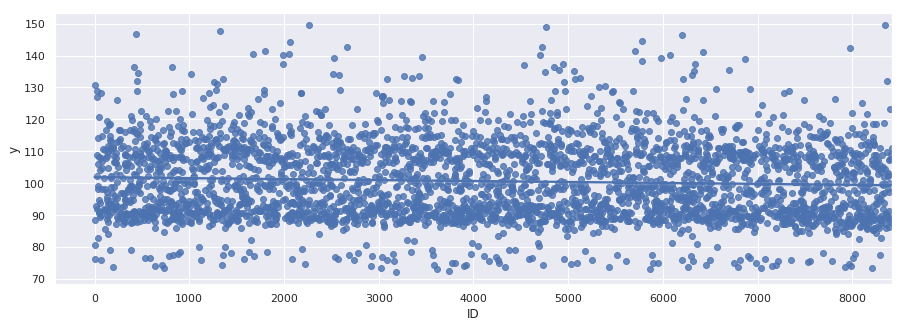

In [58]:
sns.set(rc={'figure.figsize':(15,5)})
sns.regplot(x='ID', y='y', data=train_data)

y decreases slightly with respect to ID. Thus ID is an important feature in estimating y

<h3>1.9. Feature Engineering</h3>

In [59]:
#Considering numerical columns
num_cols = train_data.drop(['ID','y','X0','X1','X2','X3','X5','X6','X8'],axis=1).columns

In [60]:
#Feature engineering considering two columns
new_num_cols_2 = []
for i in tqdm(num_cols):
    for j in num_cols:
        if i!=j and (j+'_'+i not in new_num_cols_2):
            if (train_data[i]+train_data[j]).corr(train_data['y'])>0.65:
                new_num_cols_2.append(i+'_'+j)

In [61]:
#Feature engineering considering three columns
new_num_cols_3 = []
for i in tqdm(num_cols):
    for j in num_cols:
        for k in num_cols:
            if i!=j and j!=k and i!=k and (i+'_'+k+'_'+j not in new_num_cols_3) and (j+'_'+i+'_'+k not in new_num_cols_3) 
                    and (j+'_'+k+'_'+i not in new_num_cols_3) and (k+'_'+i+'_'+j not in new_num_cols_3) 
                    and (k+'_'+j+'_'+i not in new_num_cols_3):
                if (train_data[i]+train_data[j]+train_data[k]).corr(train_data['y'])>0.65:
                    new_num_cols_3.append(i+'_'+j+'_'+k)

In [62]:
np.save('new_num_cols_3.npy',np.array(new_num_cols_3))

In [63]:
new_num_cols_3 = list(np.load('new_num_cols_3.npy'))

In [64]:
data2 = pd.DataFrame()
for i in tqdm(new_num_cols_2):
    a,b = i.split('_')
    data2[i] = train_data[a] + train_data[b]
for j in tqdm(new_num_cols_3):
    p,q,r = j.split('_')
    data2[j] = train_data[p] + train_data[q] + train_data[r]

In [65]:
dup_num_cols2 = get_duplicate_cols(data2)

In [66]:
dup_num_cols2

['X189_X198_X314',
 'X47_X66_X314',
 'X261_X315_X379',
 'X263_X314_X371',
 'X66_X261_X263',
 'X263_X314_X378',
 'X263_X314_X373',
 'X130_X261_X311',
 'X170_X261_X263',
 'X314_X315_X333',
 'X222_X261_X315',
 'X66_X189_X314',
 'X66_X119_X261',
 'X198_X311_X314',
 'X47_X198_X314',
 'X198_X263_X314',
 'X170_X263_X314',
 'X222_X314_X315',
 'X66_X311_X314',
 'X119_X195_X314',
 'X186_X187_X314',
 'X119_X130_X261',
 'X261_X263',
 'X119_X261_X314',
 'X66_X275_X314',
 'X222_X275_X314',
 'X198_X275_X314',
 'X119_X222_X314',
 'X198_X261_X315',
 'X222_X261_X263',
 'X314_X315_X379',
 'X130_X189_X261',
 'X261_X263_X371',
 'X119_X198_X314',
 'X119_X198_X261',
 'X119_X263_X314',
 'X261_X315_X373',
 'X66_X314_X315',
 'X222_X311_X314',
 'X32_X261_X263',
 'X263_X314',
 'X261_X263_X379',
 'X119_X179_X261',
 'X66_X263_X314',
 'X63_X263_X314']

In [67]:
len(dup_num_cols2)

45

In [68]:
data2 = data2.drop(columns=dup_num_cols2)

In [69]:
feature_engg = np.array(data2.columns)

In [70]:
len(feature_engg)

314

In [71]:
np.save('feature_engg.npy',feature_engg)